<img src="background_1.png">

<h1> AEQUITAS Hands-on Demonstrator </h1>

<img src="background_3.png">

<h3> Libraries </h3>

In [4]:
import sys
sys.path.append("../")
import numpy as np
import matplotlib
import pandas as pd
pd.set_option('display.width', 500)
from aequitas.engine import Aequitas, NpEncoder
import aequitas.tools.data_manip as dm
import aequitas.tools as tools
from aequitas.gateway import Gateway

<h3> Importing the dataset </h3>

In [5]:
dataset_name="IT_candidates.csv"
dataset_directory="../datasets/"+dataset_name
dataset = pd.read_csv(dataset_directory)

<h3> Dataset pre-processing </h3>

In [6]:
# Dataset already preprocessed for missing values|
dataset.drop(columns=dataset.columns[0],inplace=True)

<h3> Examples of used of the AEQUITAS object </h3>

<p> Example 1 - Empty parameters file </p>

In [6]:
parameters={ }
Aeq_dataset=Aequitas(dataset,parameters)
Aeq_dataset.structure(verbose=True)

Dataset:
        Column Name Data Type Column Type (suggestion)  Number_Values                                           Values
0               Age      text                   Binary              2                                       [<35, >35]
1     Accessibility      text                   Binary              2                                        [No, Yes]
2           EdLevel      text      Categorical/Ordinal              5  [Master, Undergraduate, PhD, Other, NoHigherEd]
3        Employment   float64                   Binary              2                                       [1.0, 0.0]
4            Gender      text      Categorical/Ordinal              3                          [Man, Woman, NonBinary]
..              ...       ...                      ...            ...                                              ...
124  Play Framework   float64                   Binary              2                                       [0.0, 1.0]
125         Phoenix   float64          

<p> Example 2 - Basic parameters file </p>

In [7]:
parameters={
    "class_attribute":{
        "name": 'Employed',
    },
}
Aeq_dataset=Aequitas(dataset,parameters)
Aeq_dataset.descriptive_stats(verbose=True)

Proportions: (Employed)
              0
True   0.536721
False  0.463279



<p> Example 3 - Parameters file with sensitive attribute definition</p>

In [8]:
parameters={
    "class_attribute":{
        "name": 'Employed',
        "positive_value":'True'
    },
    "sensitive_attributes":
    [
        {
            "name": 'Gender',
        },
        {
            "name": 'Age',
        }
    ]
}
Aeq_dataset=Aequitas(dataset,parameters)
Aeq_dataset.descriptive_stats(verbose=True)

Proportions: (Employed)
              0
True   0.536721
False  0.463279

Proportions: (Gender)
                  0
Man        0.933539
Woman      0.047794
NonBinary  0.018668

Proportions: (Age)
            0
<35  0.650949
>35  0.349051

Outcome distribution by group:
              True      False
Man        0.541235  0.458765
NonBinary  0.533966  0.466034
Woman      0.449643  0.550357

Outcome distribution by group:
        True      False
<35  0.547803  0.452197
>35  0.516056  0.483944


Association between Gender and Age.
Contingency Table:
Age          <35    >35
Gender                 
Man        44273  24189
NonBinary    895    474
Woman       2570    935

Chi-squared statistic: 109.99624855978593
Cramer's V: 0.03837502151091483
Degrees of Freedom: 2
p-value: 1.3020213636227068e-24
There is a statistically significant association between Gender and Age.

Association between Gender and Employed.
Contingency Table:
Employed   False  True 
Gender                 
Man        31408  3

<p> First connection with the context engine </p>

In [9]:
gw = Gateway('demonstrator', host='http://localhost:6060/')
fs_only = False
gw.save_element(Aeq_dataset.parameters, element_key="dataset", filesystem=fs_only)

array([[<Axes: title={'center': 'YearsCode'}>,
        <Axes: title={'center': 'YearsCodePro'}>],
       [<Axes: title={'center': 'PreviousSalary'}>,
        <Axes: title={'center': 'ComputerSkills'}>]], dtype=object)

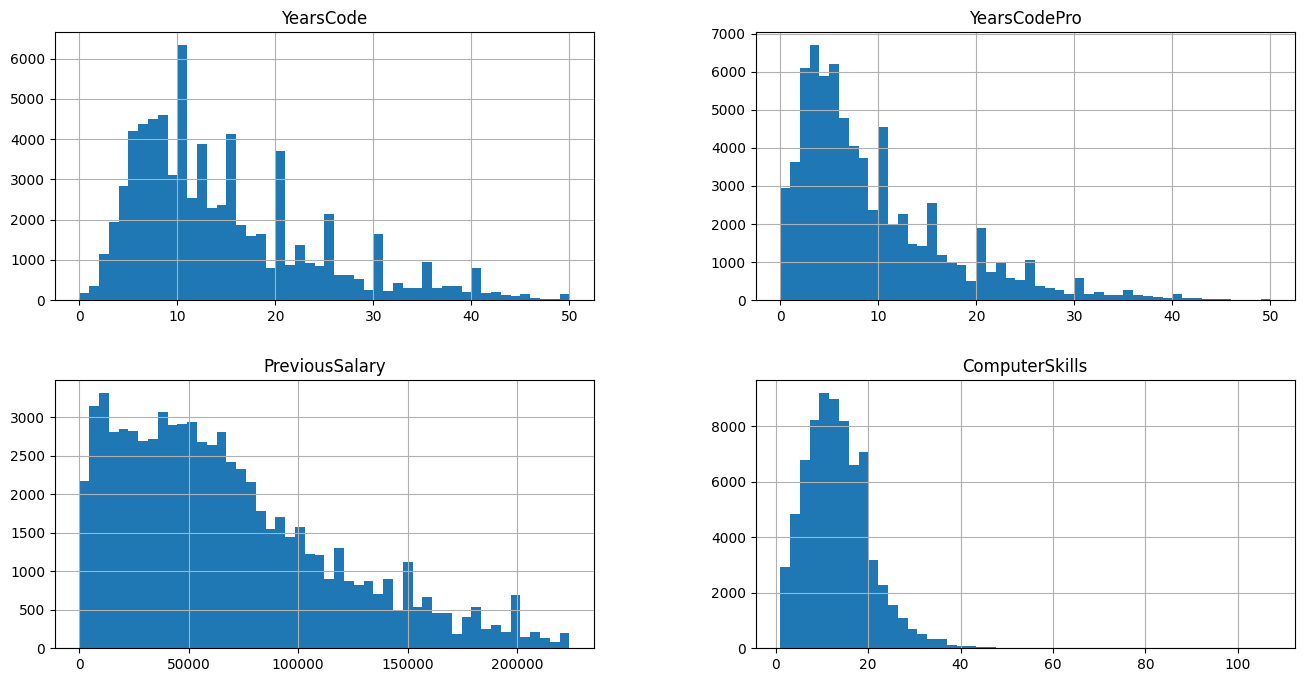

In [10]:
## Pushing gaussian distributions before the creation of the objects
numerical = dataset.select_dtypes('number').iloc[:,1:5]
numerical.hist(bins=50,figsize=(16,8))

array([[<Axes: title={'center': 'YearsCode'}>,
        <Axes: title={'center': 'YearsCodePro'}>],
       [<Axes: title={'center': 'PreviousSalary'}>,
        <Axes: title={'center': 'ComputerSkills'}>]], dtype=object)

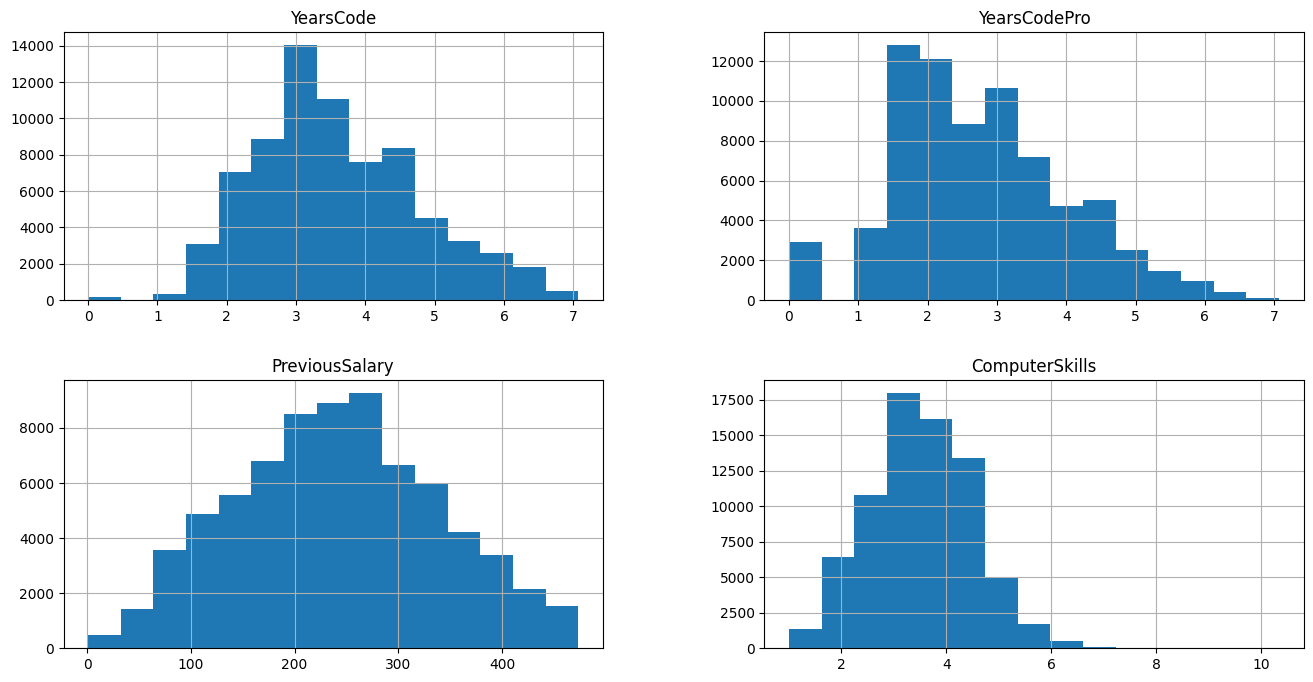

In [11]:
dataset['YearsCode']=numerical.YearsCode.apply(np.sqrt)
dataset['YearsCodePro']=numerical.YearsCodePro.apply(np.sqrt)
dataset['PreviousSalary']=numerical.PreviousSalary.apply(np.sqrt)
dataset['ComputerSkills']=numerical.ComputerSkills.apply(np.sqrt)
dataset.select_dtypes('number').iloc[:,1:5].hist(bins=15,figsize=(16,8))

<h2> Fairness analysis </h2>

<p> Splitting in training and testing samples </p>

In [12]:
training_sample,test_sample = dm.split_dataset(dataset,ratio=0.3, random_state=42)

<p> Definition of parameter file</p>

In [13]:
parameters={
    "class_attribute":{
        "name": 'Employed',
        "positive_value":'True'
    },
    "sensitive_attributes":
    [
        {
            "name": 'Gender',
        }
    ]
}

<p> Definition of the corresponding AEQUITAS Objects</p>

In [14]:
Aeq_training=Aequitas(training_sample,parameters)
Aeq_test=Aequitas(test_sample,parameters)

In [15]:
Aeq_training.structure(verbose=True)
Aeq_training.descriptive_stats()

Dataset:
        Column Name Data Type Column Type (suggestion)  Number_Values                                           Values
0               Age      text                   Binary              2                                       [<35, >35]
1     Accessibility      text                   Binary              2                                        [No, Yes]
2           EdLevel      text      Categorical/Ordinal              5  [Master, Undergraduate, Other, PhD, NoHigherEd]
3        Employment   float64                   Binary              2                                       [1.0, 0.0]
4            Gender      text      Categorical/Ordinal              3                          [Man, Woman, NonBinary]
..              ...       ...                      ...            ...                                              ...
124  Play Framework   float64                   Binary              2                                       [0.0, 1.0]
125         Phoenix   float64          

<p> Bias metrics: Statistical Parity and Disparate Impact</p>

In [16]:
Aeq_training.statistical_parity(verbose=True)

Probabilities:
           Man     Woman  NonBinary
False  0.45804  0.555419   0.464894
True   0.54196  0.444581   0.535106

Statistical/Demographic Parity:
Outcome:  False
                Man     Woman  NonBinary
Man        0.000000 -0.097380  -0.006854
Woman      0.097380  0.000000   0.090526
NonBinary  0.006854 -0.090526   0.000000

Outcome:  True
                Man     Woman  NonBinary
Man        0.000000  0.097380   0.006854
Woman     -0.097380  0.000000  -0.090526
NonBinary -0.006854  0.090526   0.000000




In [17]:
Aeq_training.disparate_impact(verbose=True)

Probabilities:
           Man     Woman  NonBinary
False  0.45804  0.555419   0.464894
True   0.54196  0.444581   0.535106

Disparate Impact:
Outcome:  False
                Man     Woman  NonBinary
Man        1.000000  1.212601   1.014964
Woman      0.824674  1.000000   0.837014
NonBinary  0.985257  1.194723   1.000000

Outcome:  True
                Man     Woman  NonBinary
Man        1.000000  0.820320   0.987353
Woman      1.219037  1.000000   1.203620
NonBinary  1.012809  0.830827   1.000000




In [18]:
# # Define appropriate transformations for dataset
# transform_dictionary = {
#     "income": {
#         "encode": "labeling",
#         "labels": {
#             "<=50K": 0,
#             ">50K": 1, 
#         }
#     },
#     "gender": {
#         "encode": "labeling",
#         "labels": {
#             "Female": 0,
#             "Male": 1, 
#         }
#     },
#     "race": {
#         "encode": "labeling",
#         "labels": {
#             "Minority": 0,
#             "White": 1, 
#         } 
#     },
#     "workclass": {
#         "encode": "labeling",
#         "scaling": "min-max"
#     },
#     "marital-status": {
#         "encode": "labeling",
#         "scaling": "min-max"
#     },
#     "occupation": {
#         "encode": "labeling", 
#         "scaling": "min-max"
#     },
#     "relationship": {
#         "encode": "labeling", 
#         "scaling": "min-max"
#     },
#     "native-country": {
#         "encode": "labeling", 
#         "scaling": "min-max"
#     },
#     "age":{
#         "scaling": "standard"
#     },
#     "educational-num":{
#         "scaling": "min-max"
#     },
#     "capital-gain":{
#         "scaling": "standard"
#     },
#     "capital-loss":{
#         "scaling": "standard"
#     },
#     "hours-per-week":{
#         "scaling": "standard"
#     }
# }

# # add transform instructions for techniques
# Aeq_training.transform_instructions(transform_dictionary)
# Aeq_test.transform_instructions(transform_dictionary)

<p> Transformation in the data for algorithmic correct processing</p>

In [19]:
transform_dictionary = {
    "Age": {
        "encode": "labeling",
    },
    "Accessibility": {
        "encode": "labeling"
    },
    "EdLevel": {
        "encode": "labeling" #Definitely should be one-hot encoding
    },
    "Employment": {
        "encode": "labeling"
    },
    # "Gender": {
    #     "encode": "one-hot"
    # },
    "Gender": {
        "encode": "labeling",
        "labels": {
            "Female": 0,
            "NonBinary": 0,
            "Male": 1, 
        }
    },
    "MentalHealth": {
        "encode": "labeling"
    },
    "MainBranch": {
        "encode": "labeling" 
    },
    "YearsCode": {
        "scaling": "standard"
    },
    "YearsCodePro":{
        "scaling": "standard"
    },
    "Country":{
        "encode": "labeling" #Definitely should be one-hot encoding
    },
    "PreviousSalary":{
        "scaling": "standard"
    },
    "ComputerSkills":{
        "scaling": "standard"
    },
}


<p> Exporting transformation instructions for the two sets </p>

In [20]:
Aeq_training.transform_instructions(transform_dictionary)
Aeq_test.transform_instructions(transform_dictionary)

<p> Appliying 'Massaging' to training dataset over the sensitive attribute 'Gender' and class 'Employed'</p>

In [21]:
Aeq_training_unbiased=Aeq_training.mitigation(method='massaging', sensitive_attribute='Gender')

/Users/rpaez/AEQUITAS/WP4/handsondemo/aequitas-lib/examples/../aequitas/mitigation/data.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  modified_data.loc[promotion[i],class_attribute]=0


<p> Re-evaluating Statistical Parity for comparison </p>

In [22]:
Aeq_training.statistical_parity(verbose=True)

Probabilities:
           Man     Woman  NonBinary
False  0.45804  0.555419   0.464894
True   0.54196  0.444581   0.535106

Statistical/Demographic Parity:
Outcome:  False
                Man     Woman  NonBinary
Man        0.000000 -0.097380  -0.006854
Woman      0.097380  0.000000   0.090526
NonBinary  0.006854 -0.090526   0.000000

Outcome:  True
                Man     Woman  NonBinary
Man        0.000000  0.097380   0.006854
Woman     -0.097380  0.000000  -0.090526
NonBinary -0.006854  0.090526   0.000000




In [23]:
Aeq_training_unbiased.statistical_parity(verbose=True)

Probabilities:
            Man     Woman  NonBinary
False  0.456371  0.555419       0.55
True   0.543629  0.444581       0.45

Statistical/Demographic Parity:
Outcome:  False
                Man     Woman  NonBinary
Man        0.000000 -0.099048  -0.093629
Woman      0.099048  0.000000   0.005419
NonBinary  0.093629 -0.005419   0.000000

Outcome:  True
                Man     Woman  NonBinary
Man        0.000000  0.099048   0.093629
Woman     -0.099048  0.000000  -0.005419
NonBinary -0.093629  0.005419   0.000000




<h3> Classification task over test sample </h3>

In [24]:
Aeq_training_unbiased.transform()
Aeq_test.transform()

In [25]:
Aeq_test.structure(verbose=True)
lista = Aeq_test.dataset.columns

Dataset:
        Column Name Data Type Column Type (suggestion)  Number_Values           Values
0               Age     int64                   Binary              2           [1, 0]
1     Accessibility     int64                   Binary              2           [0, 1]
2           EdLevel     int64      Categorical/Ordinal              5  [0, 2, 4, 1, 3]
3        Employment     int64                   Binary              2           [1, 0]
4            Gender     int64      Categorical/Ordinal              3        [0, 2, 1]
..              ...       ...                      ...            ...              ...
124  Play Framework   float64                   Binary              2       [0.0, 1.0]
125         Phoenix   float64                   Binary              2       [0.0, 1.0]
126           OCaml   float64                   Binary              2       [0.0, 1.0]
127      Colocation   float64                   Binary              2       [0.0, 1.0]
128        Solidity   float64     

<p> Define classifier parameters </p>

In [26]:
classifier_type="Decision_Tree"
classifier_params={
    "random_state":42, 
    "min_samples_leaf":10
}
class_attribute=Aeq_training_unbiased.parameters["class_attribute"]["name"]

<p> Training and testing of the classifier</p>

In [27]:
clf=tools.train_classifier(Aeq_training_unbiased.dataset,class_attribute,classifier_type,classifier_params)

predicted_test_sample, _, _, _= tools.test_classifier(clf,Aeq_test.dataset,class_attribute,verbose=True)

Aeq_training_unbiased.inverse_transform()
Aeq_test.inverse_transform()

Classifier Accuracy: 0.74


<p> Defining a new prediction on the test sample</p>

In [28]:
Aeq_predicted_test=Aeq_test.copy()
Aeq_predicted_test.set_dataset(predicted_test_sample)
Aeq_predicted_test.inverse_transform()

<p> Checking statistical parity on the new prediction <p>

In [29]:
Aeq_predicted_test.statistical_parity(verbose=True)

Probabilities:
        Man     Woman  NonBinary
1  0.533103  0.450943   0.531469
0  0.466897  0.549057   0.468531

Statistical/Demographic Parity:
Outcome:  1
                Man     Woman  NonBinary
Man        0.000000  0.082159   0.001634
Woman     -0.082159  0.000000  -0.080525
NonBinary -0.001634  0.080525   0.000000

Outcome:  0
                Man     Woman  NonBinary
Man        0.000000 -0.082159  -0.001634
Woman      0.082159  0.000000   0.080525
NonBinary  0.001634 -0.080525   0.000000




<p> Computing Equalized Odds on the prediction results</p>

In [30]:
prediction=np.array(Aeq_predicted_test.dataset[class_attribute])
Aeq_test.equal_opportunity(prediction,verbose=True)
Aeq_test.equal_odds(prediction,verbose=True)

Confusion Metrics:  (Positive_outcome='True')
             Man   NonBinary       Woman
TP   8342.000000  173.000000  342.000000
TN   6852.000000  146.000000  435.000000
FP   2593.000000   55.000000  136.000000
FN   2725.000000   55.000000  147.000000
TPR     0.753772    0.758772    0.699387
TNR     0.725463    0.726368    0.761821
FPR     0.274537    0.273632    0.238179
FNR     0.246228    0.241228    0.300613
FDR     0.237128    0.241228    0.284519
FOR     0.284536    0.273632    0.252577
PPV     0.762872    0.758772    0.715481
NPV     0.715464    0.726368    0.747423
RPP     0.533103    0.531469    0.450943
RNP     0.466897    0.468531    0.549057
ACC     0.740737    0.743590    0.733019
Equality of Opportunity:  (Positive_outcome='True')
            Man  NonBinary  Woman
Woman -0.054386  -0.059385    0.0

Confusion Metrics:  (Positive_outcome='True')
             Man   NonBinary       Woman
TP   8342.000000  173.000000  342.000000
TN   6852.000000  146.000000  435.000000
FP   259

<h3> Updating communication with context engine </h3>

In [31]:
Aeq_training_unbiased.display()
gw.save_element(Aeq_training_unbiased.parameters, element_key="dataset", version="unbiased")

Aequitas Dataset parameters:
{
    "class_attribute": {
        "name": "Employed",
        "positive_value": "True"
    },
    "sensitive_attributes": [
        {
            "name": "Gender"
        }
    ],
    "Mitigation": "True",
    "Mitigation_technique": "massaging",
    "transform_dictionary": {
        "Age": {
            "encode": "labeling"
        },
        "Accessibility": {
            "encode": "labeling"
        },
        "EdLevel": {
            "encode": "labeling"
        },
        "Employment": {
            "encode": "labeling"
        },
        "Gender": {
            "encode": "labeling",
            "labels": {
                "Female": 0,
                "NonBinary": 0,
                "Male": 1
            }
        },
        "MentalHealth": {
            "encode": "labeling"
        },
        "MainBranch": {
            "encode": "labeling"
        },
        "YearsCode": {
            "scaling": "standard"
        },
        "YearsCodePro": {
      

In [32]:
# Aeq_training.display()
# gw.save_element(Aeq_training_unbiased.parameters, element_key="dataset", version="training")

In [33]:
Aeq_test.display()
gw.save_element(Aeq_training_unbiased.parameters, element_key="dataset", version="test")

Aequitas Dataset parameters:
{
    "class_attribute": {
        "name": "Employed",
        "positive_value": "True"
    },
    "sensitive_attributes": [
        {
            "name": "Gender"
        }
    ],
    "Mitigation": "False",
    "transform_dictionary": {
        "Age": {
            "encode": "labeling"
        },
        "Accessibility": {
            "encode": "labeling"
        },
        "EdLevel": {
            "encode": "labeling"
        },
        "Employment": {
            "encode": "labeling"
        },
        "Gender": {
            "encode": "labeling",
            "labels": {
                "Female": 0,
                "NonBinary": 0,
                "Male": 1
            }
        },
        "MentalHealth": {
            "encode": "labeling"
        },
        "MainBranch": {
            "encode": "labeling"
        },
        "YearsCode": {
            "scaling": "standard"
        },
        "YearsCodePro": {
            "scaling": "standard"
        },
 